In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
split_dataset_path = r"C:\Users\mohan\OneDrive\Desktop\Plant Disease\PlantVillage_Split"
train_dir = os.path.join(split_dataset_path, 'train')
validation_dir = os.path.join(split_dataset_path, 'validation')
test_dir = os.path.join(split_dataset_path, 'test')
img_size = (128, 128)
batch_size = 32

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    label_mode='int',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 16504 files belonging to 15 classes.
Found 2058 files belonging to 15 classes.
Found 2076 files belonging to 15 classes.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names[:5]}...")


Found 15 classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']...


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
def create_model_for_finetuning():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2)
    ])
    
    base_model = MobileNetV2(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    
    
    base_model.trainable = True
    fine_tune_at = 100 
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    inputs = Input(shape=img_size + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.6)(x)  
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

model = create_model_for_finetuning()

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,921,551 (11.14 MB)

 Trainable params: 2,525,007 (9.63 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  
    patience=2,  
    min_lr=0.00001, 
    verbose=1
)


In [8]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 645s 965ms/step - accuracy: 0.6973 - loss: 1.0336 - val_accuracy: 0.2541 - val_loss: 9.9911 - learning_rate: 0.0010
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 525s 968ms/step - accuracy: 0.8841 - loss: 0.3828 - val_accuracy: 0.3017 - val_loss: 12.0135 - learning_rate: 0.0010
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 500s 969ms/step - accuracy: 0.9099 - loss: 0.2965 - val_accuracy: 0.5403 - val_loss: 3.6203 - learning_rate: 0.0010
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 497s 959ms/step - accuracy: 0.9232 - loss: 0.2544 - val_accuracy: 0.7269 - val_loss: 2.2803 - learning_rate: 0.0010
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 496s 962ms/step - accuracy: 0.9304 - loss: 0.2304 - val_accuracy: 0.8955 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 521s 998ms/step - accuracy: 0.9433 - loss: 0.1840 - val_accuracy: 0.7643 - val_loss: 1.4649 - learning_rate: 0.0010
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accurac

65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 900ms/step - accuracy: 0.9796 - loss: 0.0768
Test Accuracy: 0.9812
Test Loss: 0.0698


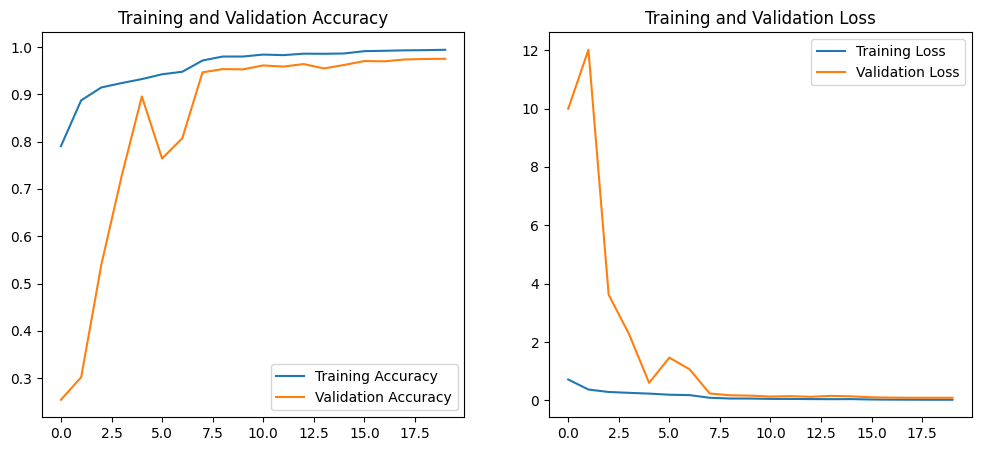

Improved and stable model saved as 'leaf_disease_model_stable.keras'


In [9]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save('leaf_disease_model_stable.keras')
print("Improved and stable model saved as 'leaf_disease_model_stable.keras'")


In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np  
import os

img_size = (128, 128)
split_dataset_path = r"C:\Users\mohan\OneDrive\Desktop\Plant Disease\PlantVillage_Split"
test_dir = os.path.join(split_dataset_path, 'test')

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    seed=123,
    image_size=img_size,
    batch_size=1
)

class_names = test_ds.class_names
print(f"Loaded {len(class_names)} class names: {class_names[:5]}...")


Found 2076 files belonging to 15 classes.
Loaded 15 class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']...


In [5]:
loaded_model = tf.keras.models.load_model('leaf_disease_model_stable.keras')
print("Model loaded successfully.")

def predict_leaf_disease(model_to_use, image_path):
    img = tf.keras.utils.load_img(image_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model_to_use.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class_index = np.argmax(score)
    predicted_class = class_names[predicted_class_index]
    try:
        leaf_name, disease_name = predicted_class.split('___')
        disease_name = disease_name.replace('_', ' ')
    except ValueError:
        parts = predicted_class.split('_')
        leaf_name = parts[0]
        disease_name = ' '.join(parts[1:]) if len(parts) > 1 else "Healthy"
    return leaf_name, disease_name, score[predicted_class_index].numpy()

Model loaded successfully.


In [9]:
import os

image_path_to_predict = r"C:\Users\mohan\OneDrive\Desktop\Plant Disease\PlantVillage_Split\test\Tomato_Late_blight\1f38b254-2338-4e4a-b772-2a8e60ca8bc0___GHLB2 Leaf 121.3.JPG"
if os.path.exists(image_path_to_predict):
    leaf, disease, *_ = predict_leaf_disease(loaded_model, image_path_to_predict)
    print(f"\nPrediction for the image:")
    print(f"Leaf: {leaf}")
    print(f"Disease: {disease}")
else:
    print(f"Error: The file '{image_path_to_predict}' was not found.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

Prediction for the image:
Leaf: Tomato
Disease: Late blight
